# Setting up environment 

In [1]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [2]:
import numpy as np 
import pandas as pd 
import random 
import io 
import os 
import cv2 
import matplotlib.pyplot as plt 
import seaborn as sns 
import time 
from tqdm import tqdm
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score,cohen_kappa_score,matthews_corrcoef
from sklearn.model_selection import train_test_split
from IPython.display import Image,display,clear_output
import pywt

import tensorflow as tf
from keras.utils.vis_utils import plot_model
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from collections import Counter

import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, CSVLogger
from tensorflow.keras.applications.vgg16 import VGG16 , preprocess_input

from tensorflow.keras import Model, layers
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dropout,Dense,Input,Conv2D,MaxPooling2D,Flatten,Activation

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
os.environ['TF_ENABLE_GPU_GARBAGE_COLLECTION'] = 'false'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

import warnings
warnings.filterwarnings('ignore')

1 Physical GPUs, 1 Logical GPUs


Number of images in training:  4770
Number of images in testing:  1311


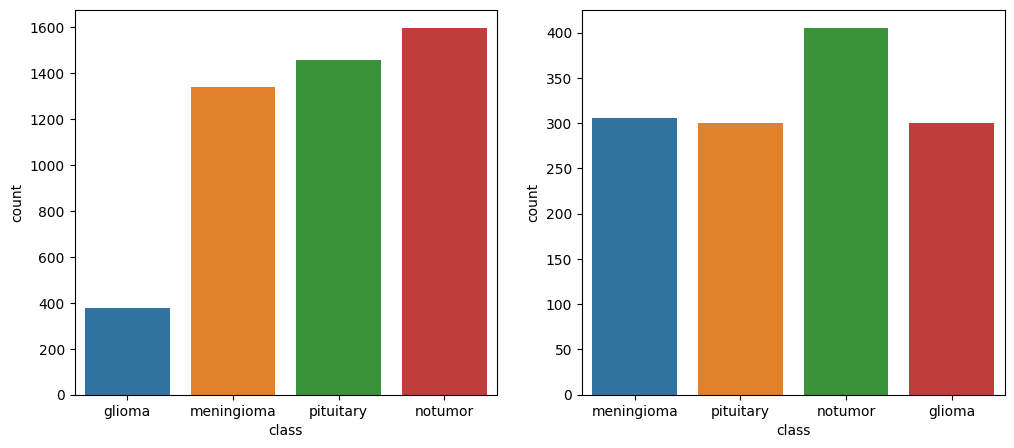

In [5]:
root_path = '/content/drive/MyDrive/brain_multi_data'
labels = []
trainFolder = root_path+'/Training/'
testFolder = root_path+'/Testing/'

quantity_tr = {} 
quantity_te = {}
for folder in os.listdir(trainFolder):
    quantity_tr[folder] = len(os.listdir(trainFolder+folder))
    labels.append(folder)
    
for folder in os.listdir(testFolder):
    quantity_te[folder] = len(os.listdir(testFolder+folder))
    
    
quantity_train = pd.DataFrame(list(quantity_tr.items()),
                              index=range(0,len(quantity_tr)), columns=['class','count'])

quantity_test = pd.DataFrame(list(quantity_te.items()),
                              index=range(0,len(quantity_te)), columns=['class','count'])

figure, ax = plt.subplots(1,2,figsize=(12,5))
sns.barplot(x='class',y='count',data=quantity_train,ax=ax[0])
sns.barplot(x='class',y='count',data=quantity_test,ax=ax[1])

print("Number of images in training: ", sum(quantity_tr.values()))
print("Number of images in testing: ", sum(quantity_te.values()))


plt.show()

#Preprocessing 

In [6]:
img_height = img_width = 150
batch_size = 50 

In [7]:
labels

['glioma', 'meningioma', 'pituitary', 'notumor']

In [8]:
# reading the dataset
X_train = []
y_train = []

X_test = []
y_test = []

for i in labels:
    folderPath = os.path.join(root_path,'Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j), 1)
        img = cv2.resize(img,(img_height, img_width))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join(root_path,'Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j), 1)
        img = cv2.resize(img,(img_height, img_width))
        X_test.append(img)
        y_test.append(i)

100%|██████████| 405/405 [00:04<00:00, 88.07it/s] 


In [9]:
# python list to numpy array
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

# Normalization 

In [10]:
print(np.min(X_train), np.max(X_train))

0 255


In [11]:
# rescaling
X_train=X_train/255.0
X_test=X_test/255.0

In [12]:
print(np.min(X_train), np.max(X_train))

0.0 1.0


In [13]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4770, 150, 150, 3) (4770,)
(1311, 150, 150, 3) (1311,)


In [14]:
# shuffle the data
#dataset are presented to the model in a random order 
X_train, y_train = shuffle(X_train, y_train, random_state=0)
X_test, y_test = shuffle(X_test, y_test, random_state=0)

In [15]:
# One Hot Encoding
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)


In [16]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4770, 150, 150, 3) (4770, 4)
(1311, 150, 150, 3) (1311, 4)


# Data Augmentation

In [17]:
train_datagen = ImageDataGenerator(        
        #rotation_range=15,
        #width_shift_range=0.05,
        #height_shift_range=0.05,
        #rescale=1./255,
        #brightness_range=[0.01, 1.5],
        #horizontal_flip=True,
        #vertical_flip=True
        #validation_split=0.1
        fill_mode="nearest",
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.1
)
test_datagen = ImageDataGenerator()


train_ds = train_datagen.flow(
  X_train, y_train,
  subset="training",
  shuffle=True,
  batch_size=batch_size)

In [18]:
import os

if not os.path.exists('preview'):
    os.mkdir('preview')
else:
    print("'preview' directory already exists.")

x = X_train[0]  
x = x.reshape((1,) + x.shape) 

i = 0
for batch in train_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break

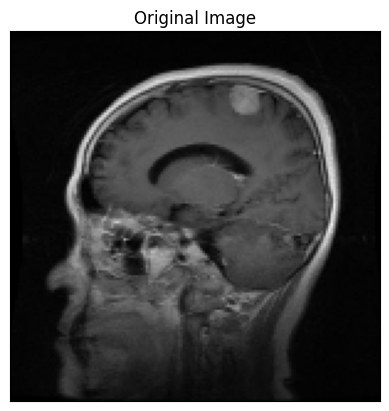

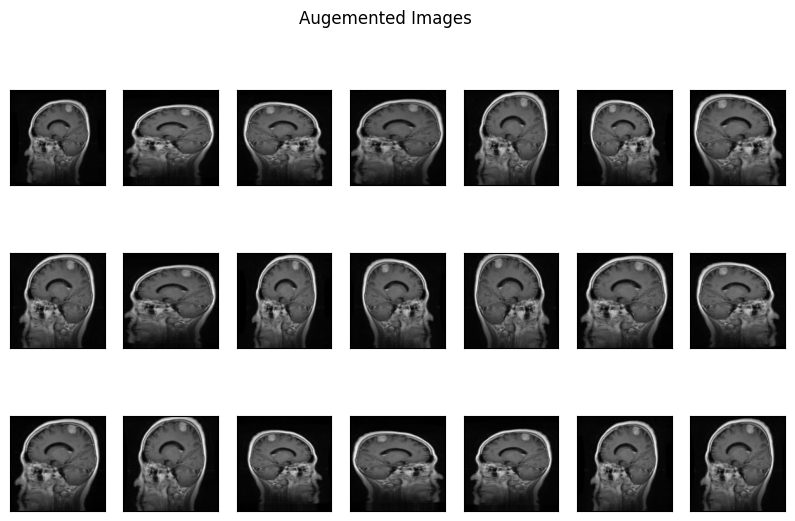

In [19]:
plt.imshow(X_train[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(10,6))
i = 1
for img in os.listdir('preview/'):
    img = cv2.imread('preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()

In [20]:
val_ds = train_datagen.flow(
  X_train, y_train,
  subset="validation",
  shuffle=True,
  batch_size=batch_size)


In [21]:
test_ds = test_datagen.flow(
  X_test, y_test,
  shuffle=False,
  batch_size=batch_size)

In [22]:
j = 0
class_mapping = {}
for i in labels:
    class_mapping[j] = i
    j+=1
    
class_mapping

{0: 'glioma', 1: 'meningioma', 2: 'pituitary', 3: 'notumor'}

In [23]:
def show_few_images(number_of_examples=2, predict_using_model=None):
    figure1, ax1 = plt.subplots(number_of_examples,len(os.listdir(testFolder)), figsize=(20,4*number_of_examples))
    ax1 = ax1.reshape(-1)
    axoff_fun = np.vectorize(lambda ax:ax.axis('off'))
    axoff_fun(ax1)
    axs = 0
    for i, folder in enumerate(os.listdir(testFolder)):
        image_ids = os.listdir(os.path.join(testFolder,folder))
        for j in [random.randrange(0, len(image_ids)) for i in range(0,number_of_examples)]:
            
            display = cv2.imread(os.path.join(testFolder,folder,image_ids[j]),1)
            display = cv2.resize(display, (img_height, img_width))/255.0
            plt.axis('off')
            ax1[axs].imshow(display)
            title = 'True: '+folder
            if(predict_using_model):
                result = predict_using_model.predict(np.array([display]))
                #print(result)
                acc = str(round(np.max(result)*100, 3))
                predicted_classname = class_mapping[np.argmax(result)]
                title = title+'\nPrediction : '+predicted_classname+" - "+acc+"%"
            ax1[axs].set_title(title)
            axs=axs+1

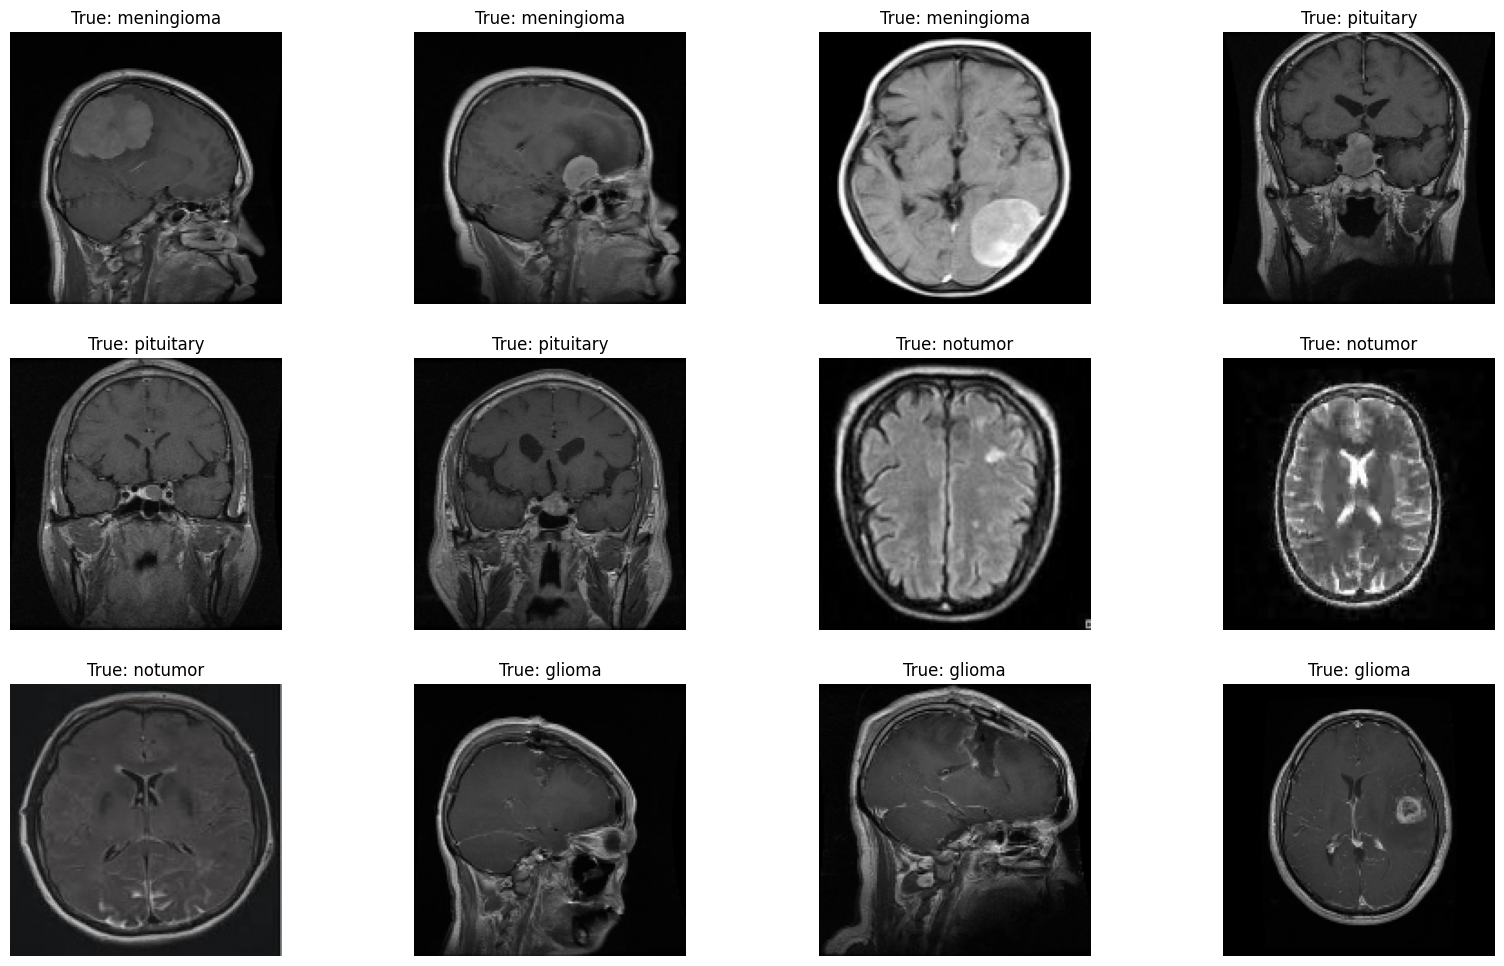

In [24]:
show_few_images(3)

In [25]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break


(50, 150, 150, 3)
(50, 4)


In [26]:
tf.keras.backend.clear_session()

# epoch config
epoch = 30

# Sequential Model

In [27]:

sequential_model = Sequential(
    [
        layers.Conv2D(32, (3, 3), input_shape=(img_height, img_width, 3), activation="relu", name="Conv1"),
        layers.MaxPooling2D(pool_size=(2, 2), name="Max_Pool_1"),
        
        layers.Conv2D(32, (3, 3), activation="relu", name="Conv2"),
        layers.MaxPooling2D(pool_size=(2, 2), name="Max_Pool_2"),
        
        layers.Conv2D(64, (3, 3), activation="relu", name="Conv3"),
        layers.MaxPooling2D(pool_size=(2, 2), name="Max_Pool_3"),
        
        layers.Flatten(),
        layers.Dense(256, activation="relu", name="fc1"),
        layers.Dropout(0.5),
        layers.Dense(4, activation="softmax", name="fc2"),    
    ]
    
)

sequential_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
sequential_model.summary()
          

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 148, 148, 32)      896       
                                                                 
 Max_Pool_1 (MaxPooling2D)   (None, 74, 74, 32)        0         
                                                                 
 Conv2 (Conv2D)              (None, 72, 72, 32)        9248      
                                                                 
 Max_Pool_2 (MaxPooling2D)   (None, 36, 36, 32)        0         
                                                                 
 Conv3 (Conv2D)              (None, 34, 34, 64)        18496     
                                                                 
 Max_Pool_3 (MaxPooling2D)   (None, 17, 17, 64)        0         
                                                                 
 flatten (Flatten)           (None, 18496)             0

In [28]:
checkpoint_path = "/content/drive/MyDrive/checkpoints/model_checkpoint.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)


callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                       verbose=1,
                                       save_best_only=True,
                                       monitor = 'val_loss',
                                       mode='min'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                        factor=0.3,
                                        patience=2,
                                        verbose=1,
                                        mode='auto',
                                        min_delta=0.0001),
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
    CSVLogger("/content/drive/MyDrive/training_log.csv", separator=',', append=False),
]

In [29]:
# train history

history = sequential_model.fit(train_ds,
                               epochs=epoch, 
                               verbose=1, 
                               validation_data = val_ds,
                               callbacks=callbacks)
#pd.DataFrame(history)


Epoch 1/30
86/86 [==============================] - ETA: 0s - loss: 0.8324 - acc: 0.6529
Epoch 1: val_loss improved from inf to 0.60126, saving model to /content/drive/MyDrive/checkpoints/model_checkpoint.ckpt


86/86 [==============================] - 40s 321ms/step - loss: 0.8324 - acc: 0.6529 - val_loss: 0.6013 - val_acc: 0.7799 - lr: 0.0010
Epoch 2/30
86/86 [==============================] - ETA: 0s - loss: 0.5797 - acc: 0.7880
Epoch 2: val_loss improved from 0.60126 to 0.46890, saving model to /content/drive/MyDrive/checkpoints/model_checkpoint.ckpt


86/86 [==============================] - 26s 298ms/step - loss: 0.5797 - acc: 0.7880 - val_loss: 0.4689 - val_acc: 0.8595 - lr: 0.0010
Epoch 3/30
86/86 [==============================] - ETA: 0s - loss: 0.4774 - acc: 0.8248
Epoch 3: val_loss improved from 0.46890 to 0.45304, saving model to /content/drive/MyDrive/checkpoints/model_checkpoint.ckpt


86/86 [==============================] - 25s 292ms/step - loss: 0.4774 - acc: 0.8248 - val_loss: 0.4530 - val_acc: 0.8512 - lr: 0.0010
Epoch 4/30
86/86 [==============================] - ETA: 0s - loss: 0.4225 - acc: 0.8558
Epoch 4: val_loss improved from 0.45304 to 0.39868, saving model to /content/drive/MyDrive/checkpoints/model_checkpoint.ckpt


86/86 [==============================] - 25s 292ms/step - loss: 0.4225 - acc: 0.8558 - val_loss: 0.3987 - val_acc: 0.8784 - lr: 0.0010
Epoch 5/30
86/86 [==============================] - ETA: 0s - loss: 0.3680 - acc: 0.8733
Epoch 5: val_loss improved from 0.39868 to 0.33352, saving model to /content/drive/MyDrive/checkpoints/model_checkpoint.ckpt


86/86 [==============================] - 27s 315ms/step - loss: 0.3680 - acc: 0.8733 - val_loss: 0.3335 - val_acc: 0.8763 - lr: 0.0010
Epoch 6/30
86/86 [==============================] - ETA: 0s - loss: 0.3216 - acc: 0.8856
Epoch 6: val_loss improved from 0.33352 to 0.31642, saving model to /content/drive/MyDrive/checkpoints/model_checkpoint.ckpt


86/86 [==============================] - 25s 291ms/step - loss: 0.3216 - acc: 0.8856 - val_loss: 0.3164 - val_acc: 0.8931 - lr: 0.0010
Epoch 7/30
86/86 [==============================] - ETA: 0s - loss: 0.2895 - acc: 0.9017
Epoch 7: val_loss improved from 0.31642 to 0.29688, saving model to /content/drive/MyDrive/checkpoints/model_checkpoint.ckpt


86/86 [==============================] - 27s 310ms/step - loss: 0.2895 - acc: 0.9017 - val_loss: 0.2969 - val_acc: 0.9057 - lr: 0.0010
Epoch 8/30
86/86 [==============================] - ETA: 0s - loss: 0.2533 - acc: 0.9157
Epoch 8: val_loss improved from 0.29688 to 0.25022, saving model to /content/drive/MyDrive/checkpoints/model_checkpoint.ckpt


86/86 [==============================] - 27s 312ms/step - loss: 0.2533 - acc: 0.9157 - val_loss: 0.2502 - val_acc: 0.9203 - lr: 0.0010
Epoch 9/30
86/86 [==============================] - ETA: 0s - loss: 0.2352 - acc: 0.9194
Epoch 9: val_loss improved from 0.25022 to 0.24591, saving model to /content/drive/MyDrive/checkpoints/model_checkpoint.ckpt


86/86 [==============================] - 25s 286ms/step - loss: 0.2352 - acc: 0.9194 - val_loss: 0.2459 - val_acc: 0.9245 - lr: 0.0010
Epoch 10/30
86/86 [==============================] - ETA: 0s - loss: 0.2261 - acc: 0.9217
Epoch 10: val_loss did not improve from 0.24591
86/86 [==============================] - 23s 271ms/step - loss: 0.2261 - acc: 0.9217 - val_loss: 0.2520 - val_acc: 0.9224 - lr: 0.0010
Epoch 11/30
86/86 [==============================] - ETA: 0s - loss: 0.1937 - acc: 0.9315
Epoch 11: val_loss improved from 0.24591 to 0.22305, saving model to /content/drive/MyDrive/checkpoints/model_checkpoint.ckpt


86/86 [==============================] - 23s 271ms/step - loss: 0.1937 - acc: 0.9315 - val_loss: 0.2230 - val_acc: 0.9371 - lr: 0.0010
Epoch 12/30
86/86 [==============================] - ETA: 0s - loss: 0.1567 - acc: 0.9464
Epoch 12: val_loss improved from 0.22305 to 0.19317, saving model to /content/drive/MyDrive/checkpoints/model_checkpoint.ckpt


86/86 [==============================] - 25s 296ms/step - loss: 0.1567 - acc: 0.9464 - val_loss: 0.1932 - val_acc: 0.9497 - lr: 0.0010
Epoch 13/30
86/86 [==============================] - ETA: 0s - loss: 0.1475 - acc: 0.9464
Epoch 13: val_loss improved from 0.19317 to 0.18591, saving model to /content/drive/MyDrive/checkpoints/model_checkpoint.ckpt


86/86 [==============================] - 24s 283ms/step - loss: 0.1475 - acc: 0.9464 - val_loss: 0.1859 - val_acc: 0.9455 - lr: 0.0010
Epoch 14/30
86/86 [==============================] - ETA: 0s - loss: 0.1401 - acc: 0.9550
Epoch 14: val_loss did not improve from 0.18591
86/86 [==============================] - 28s 323ms/step - loss: 0.1401 - acc: 0.9550 - val_loss: 0.2476 - val_acc: 0.9308 - lr: 0.0010
Epoch 15/30
86/86 [==============================] - ETA: 0s - loss: 0.1351 - acc: 0.9536
Epoch 15: val_loss did not improve from 0.18591

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
86/86 [==============================] - 24s 274ms/step - loss: 0.1351 - acc: 0.9536 - val_loss: 0.2510 - val_acc: 0.9308 - lr: 0.0010
Epoch 16/30
86/86 [==============================] - ETA: 0s - loss: 0.1008 - acc: 0.9632
Epoch 16: val_loss improved from 0.18591 to 0.18305, saving model to /content/drive/MyDrive/checkpoints/model_checkpoint.ckpt


86/86 [==============================] - 25s 288ms/step - loss: 0.1008 - acc: 0.9632 - val_loss: 0.1830 - val_acc: 0.9539 - lr: 3.0000e-04
Epoch 17/30
86/86 [==============================] - ETA: 0s - loss: 0.0882 - acc: 0.9688
Epoch 17: val_loss improved from 0.18305 to 0.16729, saving model to /content/drive/MyDrive/checkpoints/model_checkpoint.ckpt


86/86 [==============================] - 25s 295ms/step - loss: 0.0882 - acc: 0.9688 - val_loss: 0.1673 - val_acc: 0.9581 - lr: 3.0000e-04
Epoch 18/30
86/86 [==============================] - ETA: 0s - loss: 0.0826 - acc: 0.9732
Epoch 18: val_loss did not improve from 0.16729
86/86 [==============================] - 23s 273ms/step - loss: 0.0826 - acc: 0.9732 - val_loss: 0.1760 - val_acc: 0.9581 - lr: 3.0000e-04
Epoch 19/30
86/86 [==============================] - ETA: 0s - loss: 0.0705 - acc: 0.9769
Epoch 19: val_loss did not improve from 0.16729

Epoch 19: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
86/86 [==============================] - 22s 256ms/step - loss: 0.0705 - acc: 0.9769 - val_loss: 0.1967 - val_acc: 0.9539 - lr: 3.0000e-04
Epoch 20/30
86/86 [==============================] - ETA: 0s - loss: 0.0661 - acc: 0.9790
Epoch 20: val_loss did not improve from 0.16729
86/86 [==============================] - 23s 273ms/step - loss: 0.0661 - acc: 0.9790 - val_

# Model Evaluation 

In [30]:
import pandas as pd

history_dict = history.history  # Assuming `history` is the object returned by `model.fit()`

# Create a DataFrame from the history dictionary
history_df = pd.DataFrame(history_dict)

# Rename the column 'val_accuracy' to 'val_acc'
history_df.rename(columns={'val_accuracy': 'val_acc'}, inplace=True)


In [31]:
# train
import pandas as pd
pd.DataFrame(history.history)

,loss,acc,val_loss,val_acc,lr
0,0.832425,0.652923,0.601255,0.779874,0.001000
1,0.579746,0.788027,0.468895,0.859539,0.001000
2,0.477388,0.824831,0.453036,0.851153,0.001000
3,0.422527,0.855812,0.398683,0.878407,0.001000
4,0.367951,0.873282,0.333523,0.876310,0.001000
5,0.321615,0.885628,0.316419,0.893082,0.001000
6,0.289518,0.901700,0.296883,0.905660,0.001000
7,0.253272,0.915677,0.250219,0.920335,0.001000
8,0.235171,0.919404,0.245905,0.924528,0.001000
9,0.226093,0.921733,0.252012,0.922432,0.001000


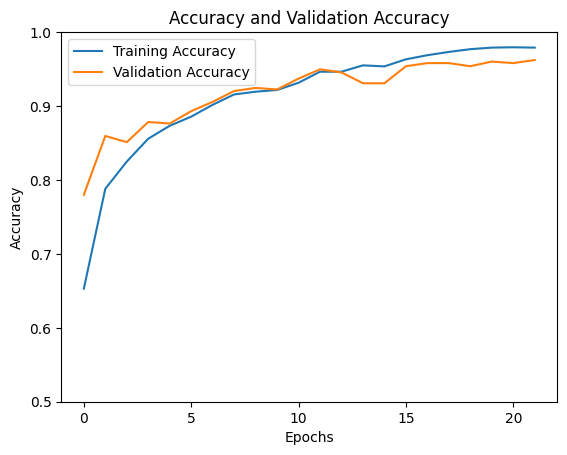

In [32]:
import matplotlib.pyplot as plt

# Assume `history` is the object obtained from model.fit()

# Get the accuracy and validation accuracy values from history
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']

# Create the plot
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.0])  # Set the range of the y-axis
plt.legend()
plt.show()

<Axes: >

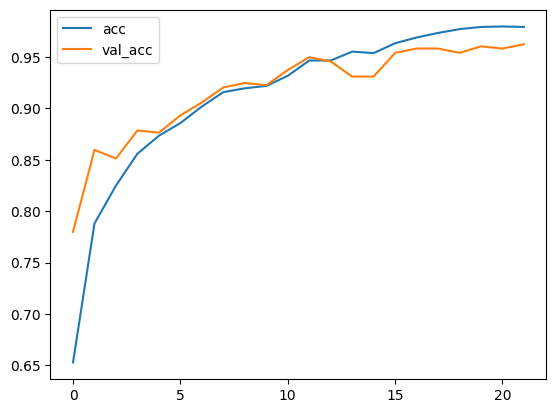

In [33]:
pd.DataFrame(history.history)[['acc', 'val_acc']].plot()

<Axes: >

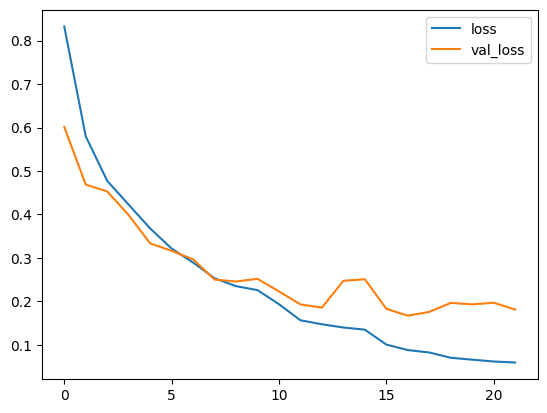

In [34]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()

In [35]:
sequential_model.evaluate(X_train, y_train)


150/150 [==============================] - 2s 10ms/step - loss: 0.0487 - acc: 0.9860


[0.04874923825263977, 0.9859538674354553]

In [36]:
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

# conf matrix 

In [37]:
predictions = sequential_model.predict(X_test)
#print(predictions)


41/41 [==============================] - 1s 13ms/step


In [38]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Assuming `labels` is a list
print(len(labels))  # Print the length/dimensions of `labels`

# Assuming `predictions` is a list
print(len(predictions))  # Print the length/dimensions of `predictions`


4
1311


41/41 [==============================] - 0s 8ms/step


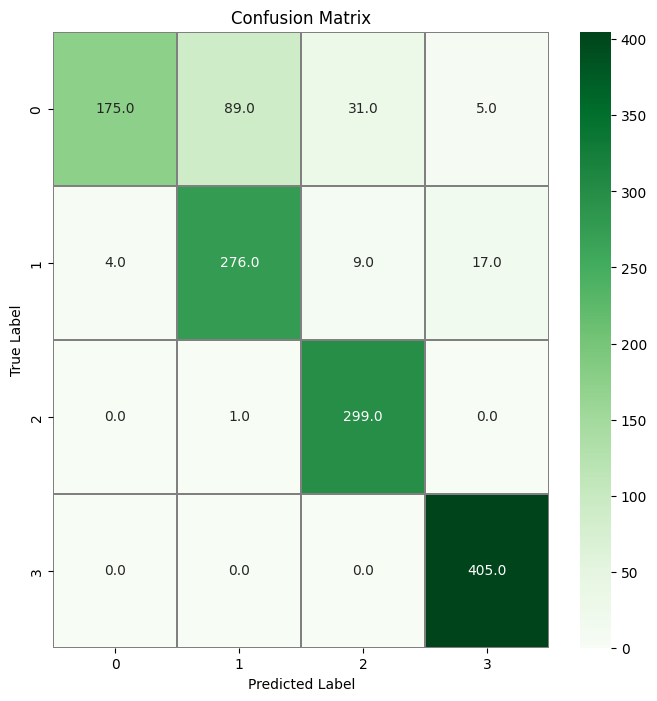

In [39]:
# confusion matrix : test 
import seaborn as sns
# Predict the values from the validation dataset
y_pred = sequential_model.predict(X_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [40]:
y_preds = np.argmax(y_pred)
y_test = np.array(y_test)

In [41]:
y_pred_labels = np.argmax(y_pred)

# Print the predicted labels
print(y_pred_labels)

79


#display image

41/41 [==============================] - 0s 7ms/step


<function matplotlib.pyplot.show(close=None, block=None)>

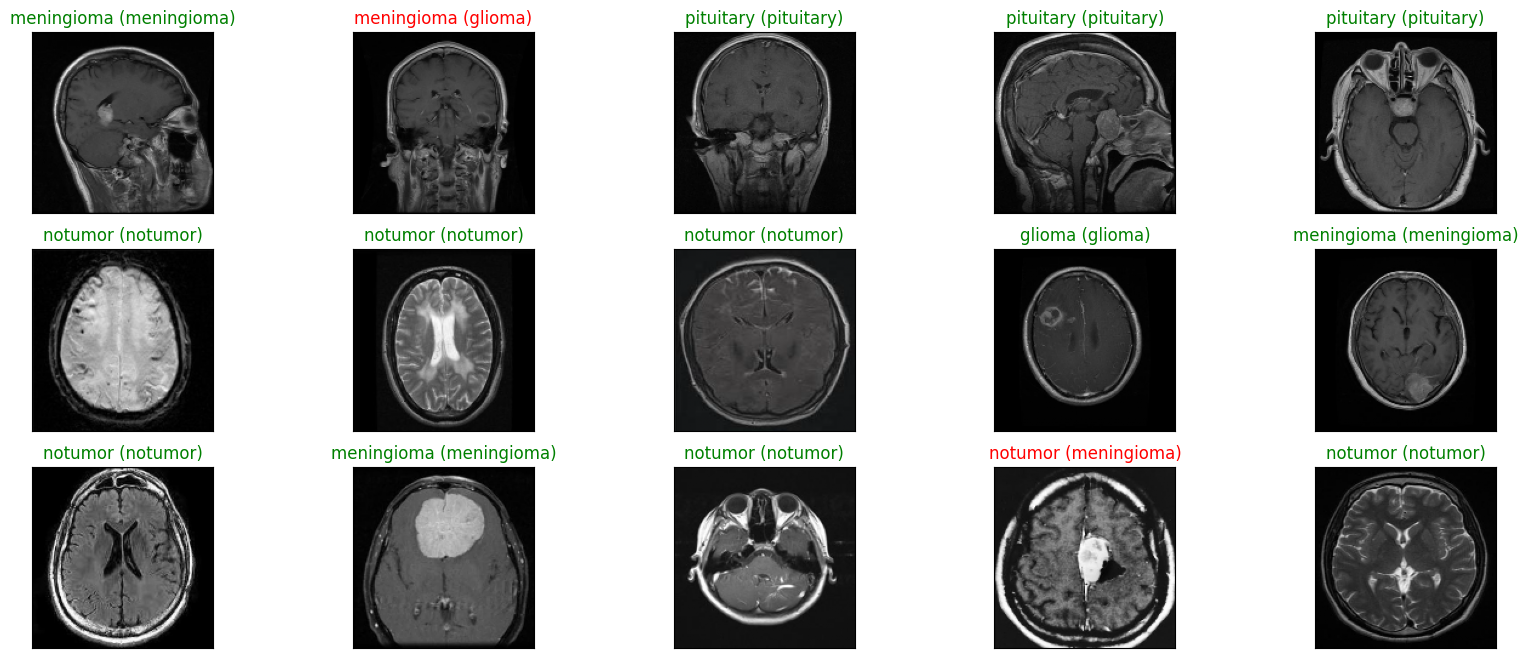

In [42]:
labels = ['glioma', 'meningioma', 'pituitary', 'notumor']
y_hat = sequential_model.predict(X_test)

# Plot A random sample of 15 test datasets, their predicted labels and actual o/p
figure = plt.figure(figsize = (20,8))

for i, index in enumerate(np.random.choice(X_test.shape[0], size = 15, replace=False)):
  ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
  # display test image using plt
  ax.imshow(np.squeeze(X_test[index]))
  # Predicted o/p
  predicted_index = np.argmax(y_hat[index])
  # actual value
  true_index = np.argmax(y_test[index])
  ax.set_title("{} ({})".format(labels[predicted_index], 
                                 labels[true_index]),
                                 color=("green" if predicted_index == true_index else "red"))
plt.show

# Test Accuracy

In [43]:
sequential_model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['accuracy'] )
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
test_loss, test_acc = sequential_model.evaluate(test_ds, batch_size=32, callbacks= callbacks)
print("test loss: %.2f, test acc: %.2f"%(test_loss, test_acc))

Evaluate on test data
27/27 [==============================] - 1s 24ms/step - loss: 0.5257 - accuracy: 0.8810
test loss: 0.53, test acc: 0.88


In [44]:
# evaluate model on private test set
score = sequential_model.evaluate(X_test, y_test, verbose=0)
print ("model %s: %.2f%%" % (sequential_model.metrics_names[1], score[1]*100))

model accuracy: 88.10%


# Show Images 

1/1 [==============================] - 0s 20ms/step


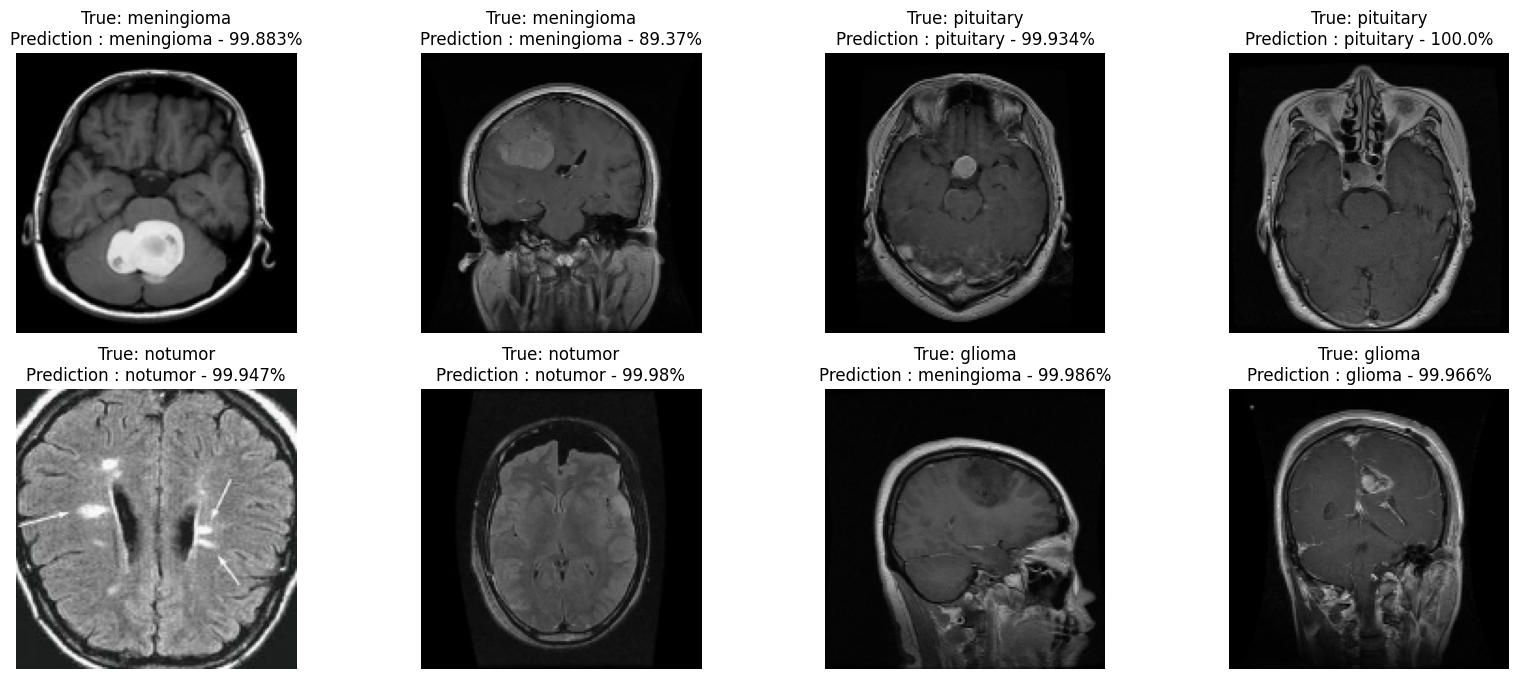

In [45]:
show_few_images(2, sequential_model)
#plt.savefig("img/trueVSpread_cnn.jpg", dpi=1000, bbox_inches='tight')

Test Evaluation


In [46]:
# evaluate model on private test set
score = sequential_model.evaluate(X_test, y_test, verbose=0)
print ("model %s: %.2f%%" % (sequential_model.metrics_names[1], score[1]*100))

model accuracy: 88.10%


In [47]:
from sklearn.metrics import classification_report

# Assuming you have the true labels (y_true) and predicted labels (y_pred) for your multiclass classification
y_pred_labels = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

report = classification_report(y_true, y_pred_labels)
print(report)


              precision    recall  f1-score   support

           0       0.98      0.58      0.73       300
           1       0.75      0.90      0.82       306
           2       0.88      1.00      0.94       300
           3       0.95      1.00      0.97       405

    accuracy                           0.88      1311
   macro avg       0.89      0.87      0.87      1311
weighted avg       0.89      0.88      0.87      1311

